## Import Libraries

In [24]:
import pandas as pd
#Import Libraries
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np

## Prepare Data

### Soothe Healthcare

In [62]:
folder = '../Data/Contoso/'

df_dimchannel = pd.read_csv(os.path.join(folder, 'DimChannel.csv'))
df_dimstore = pd.read_csv(os.path.join(folder, 'DimStore.csv'))
df_dimproduct = pd.read_csv(os.path.join(folder, 'DimProduct.csv'))
df_dimproductcategory = pd.read_csv(os.path.join(folder, 'DimProductCategory.csv'))
df_dimproductsubcategory = pd.read_csv(os.path.join(folder, 'DimProductSubcategory.csv'))
df_dimpromotion = pd.read_csv(os.path.join(folder, 'DimPromotion.csv'))
df_dimcurrency = pd.read_csv(os.path.join(folder, 'DimCurrency.csv'))
df_dimgeography = pd.read_csv(os.path.join(folder, 'DimGeography.csv'))

In [63]:
folder = '../Data/Soothe Healthcare/'
df_factsales = pd.read_csv(os.path.join(folder, 'Sales.csv'))

num_sales_rows = df_factsales.shape[0]
Continent = ['Asia', 'Europe', 'North America']
df_factsales['Continent'] = np.random.choice(Continent, size=num_sales_rows)

Item_Sub_Category_dict = {}
actual_list = list(df_factsales['Item Sub Category'].unique())
new_list = list(df_dimproductsubcategory['ProductSubcategoryName'].unique()) + ['Lamps', 'Air Conditioners', 'Fans']
for i in range(len(actual_list)):
    Item_Sub_Category_dict[actual_list[i]] = new_list[i]

df_factsales['Item Sub Category'] = df_factsales['Item Sub Category'].replace(Item_Sub_Category_dict)
df_factsales = pd.merge(pd.merge(df_factsales, df_dimproductsubcategory[['ProductSubcategoryName', 'ProductCategoryKey']], left_on = 'Item Sub Category', right_on = 'ProductSubcategoryName'), df_dimproductcategory, left_on = 'ProductCategoryKey', right_on = 'ProductCategoryKey').drop(['Item Sub Category', 'ProductCategoryKey'], axis = 1)

customer_group_dict = {}
actual_list = list(df_factsales['Customer Group'].unique())
new_list = list(df_dimgeography[df_dimgeography['GeographyType'] == 'Country/Region']['RegionCountryName'])
for i in range(len(actual_list)):
    customer_group_dict[actual_list[i]] = new_list[i]

df_factsales['Country'] = df_factsales['Customer Group'].replace(customer_group_dict)
df_factsales.drop(['Customer Group', 'Document'], axis = 1, inplace = True)

In [64]:
df_sales = df_factsales.copy()

date_column = 'Invoice date'
predict_column = 'Total Invoice Value'

df_sales.drop(['PCS Qty'], axis = 1, inplace = True)

## FE

In [65]:
def extract_date_components(df_sales, date_column):
    # Convert 'Invoice date' column to datetime if it's not already
    df_sales.loc[:, date_column] = pd.to_datetime(df_sales[date_column])
    
    # Extract year, quarter, month, week, weekofmonth, day, and is_weekend
    df_sales.loc[:, 'Year'] = df_sales[date_column].dt.year
    df_sales.loc[:, 'Quarter'] = df_sales[date_column].dt.quarter
    df_sales.loc[:, 'Month'] = df_sales[date_column].dt.month
    df_sales.loc[:, 'Week'] = df_sales[date_column].dt.isocalendar().week
    df_sales.loc[:, 'WeekOfMonth'] = df_sales[date_column].dt.day // 7 + 1
    df_sales.loc[:, 'Day'] = df_sales[date_column].dt.day
    df_sales.loc[:, 'Is_Weekend'] = df_sales[date_column].dt.dayofweek // 5
    df_sales.loc[:, 'DayOfWeek'] = df_sales[date_column].dt.dayofweek
    df_sales.loc[:, 'DayOfYear'] = df_sales[date_column].dt.dayofyear
    df_sales['is_start_of_month'] = df_sales[date_column].dt.is_month_start.astype(int)
    df_sales['is_end_of_month'] = df_sales[date_column].dt.is_month_end.astype(int)
    # df_sales['Is_First_Half_Of_Month'] = df_sales['Invoice date'].dt.day <= 10
    # df_sales['Is_Mid_Month'] = (df_sales['Invoice date'].dt.day > 10) & (df_sales['Invoice date'].dt.day <= 20)
    # df_sales['Is_Second_Half_Of_Month'] = df_sales['Invoice date'].dt.day > 20
    

    def get_season(month):
        if 3 <= month <= 5:
            return 1 #'Spring'
        elif 6 <= month <= 8:
            return 2 #'Summer'
        elif 9 <= month <= 11:
            return 3 #'Autumn'
        else:
            return 4 #'Winter'

    df_sales['season'] = df_sales[date_column].dt.month.apply(get_season)
    df_sales.sort_values(by = date_column, ascending = True, inplace = True)
    # df_sales.drop([date_column], axis = 1, inplace = True)
    
    return df_sales


In [66]:
# List of categorical columns to encode
catg_columns = ['Continent', 'ProductSubcategoryName', 'ProductCategoryName', 'Country']

# Dictionary to store label encoders
label_encoders = {}

# Label Encode the categorical columns
for col in catg_columns:
    le = LabelEncoder()
    df_sales[col] = le.fit_transform(df_sales[col])
    label_encoders[col] = le

df_sales.sort_values(by = date_column, ascending = True, inplace = True)

In [68]:
df_sales_aggr = df_sales.groupby([date_column, 'Continent', 'ProductSubcategoryName', 'ProductCategoryName', 'Country'])[[predict_column]].sum().reset_index()
df_sales_aggr_ml = df_sales_aggr.copy()
df_sales_aggr_ml[date_column] = pd.to_datetime(df_sales_aggr_ml[date_column])
df_sales_aggr_ml = extract_date_components(df_sales_aggr_ml, date_column)

## Train Test Split

In [72]:
split_index = int(len(df_sales_aggr_ml) * 0.9)
train_df = df_sales_aggr_ml.iloc[:split_index]
test_df = df_sales_aggr_ml.iloc[split_index:]

# Train RF model
X_train = train_df.drop(columns=[predict_column, date_column])
y_train = train_df[predict_column]
X_test = test_df.drop(columns=[predict_column, date_column])
y_test = test_df[predict_column]

## RF Model

In [74]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
r2_rf = r2_score(y_test, y_pred)
print("R-squared (R2) Score for Random Forest:", r2_rf)

R-squared (R2) Score for Random Forest: 0.7606788436665352


## XG Boost

In [75]:
xgb_params = {
    'n_estimators': 10,
    'objective': 'reg:squarederror',
    'random_state': 42
}
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)
# Step 4: Evaluate Model Performance
y_pred = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred)
print("R-squared (R2) Score for XGBoost:", r2_xgb)

R-squared (R2) Score for XGBoost: 0.7719910495425956


## Final Model

In [76]:
X_train = df_sales_aggr_ml.drop(columns=[predict_column, date_column])
y_train = df_sales_aggr_ml[predict_column]

if r2_rf > r2_xgb:
    model = 'Random Forest'
    random_forest = RandomForestRegressor(random_state=42)
    random_forest.fit(X_train, y_train)
    final_model = random_forest
    r2 = r2_rf
else:
    model = 'XGBoost'
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train)
    final_model = xgb_model
    r2 = r2_xgb


## Validation

In [86]:
y_pred = list(final_model.predict(X_test))
y_test = list(y_test)

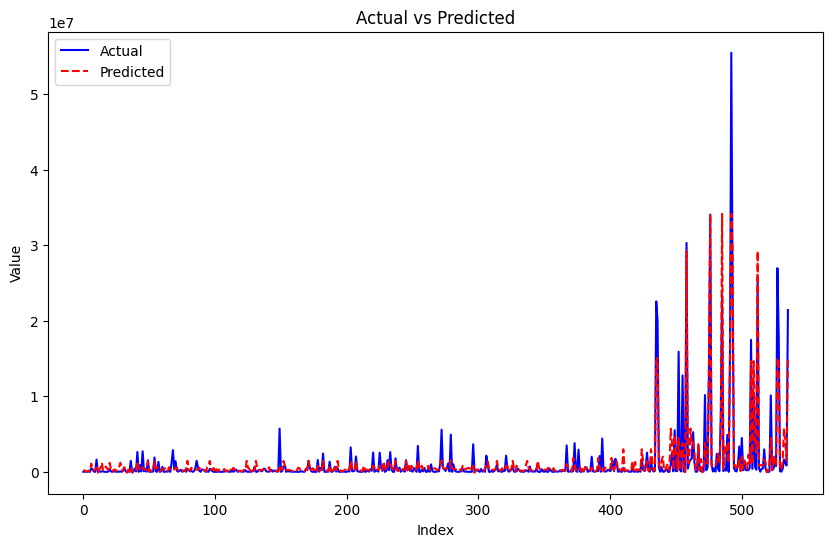

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

## Save model

In [90]:
import joblib
joblib.dump(final_model, 'final_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [92]:
X_test

,Continent,ProductSubcategoryName,ProductCategoryName,Country,Year,Quarter,Month,Week,WeekOfMonth,Day,Is_Weekend,DayOfWeek,DayOfYear,is_start_of_month,is_end_of_month,season
4805,0,33,0,2,2023,3,9,37,3,15,0,4,258,0,0,3
4806,0,33,0,4,2023,3,9,37,3,15,0,4,258,0,0,3
4807,0,41,7,4,2023,3,9,37,3,15,0,4,258,0,0,3
4808,1,7,7,7,2023,3,9,37,3,15,0,4,258,0,0,3
4809,1,19,0,3,2023,3,9,37,3,15,0,4,258,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,0,40,2,7,2023,3,9,39,5,30,1,5,273,0,1,3
5284,0,39,7,7,2023,3,9,39,5,30,1,5,273,0,1,3
5283,0,39,7,5,2023,3,9,39,5,30,1,5,273,0,1,3
5293,1,7,7,7,2023,3,9,39,5,30,1,5,273,0,1,3


## Predict

In [78]:
# Create future dates
min_date = df_sales_aggr_ml[date_column].max()
min_date = min_date + pd.Timedelta(days=1)
max_date = min_date + pd.Timedelta(days=151)
date_range = pd.date_range(start=min_date, end=max_date, freq='D')  # freq='D' for daily frequency
date_df = pd.DataFrame(date_range, columns=[date_column])
date_df = extract_date_components(date_df, date_column)

In [79]:
X_future = date_df.drop(columns=[date_column])
y_future = final_model.predict(X_future)

## Forecast Plot

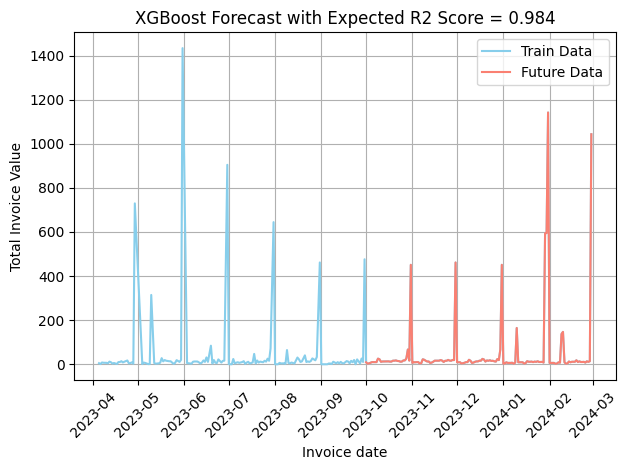

In [12]:
# Plot the chart
X_future[date_column] = pd.to_datetime(X_future[['Year', 'Month', 'Day']])
X_future[predict_column] = y_future
plot_future = X_future.set_index(date_column)[predict_column]

X_train[date_column] = pd.to_datetime(X_train[['Year', 'Month', 'Day']])
X_train[predict_column] = y_train
plot_train = df_sales_aggr_ml.set_index(date_column)[predict_column]

plot_data = pd.concat([plot_train, plot_future])
plot_data /= 1e6
plot_data.index = pd.to_datetime(plot_data.index)
# Find peaks
# peaks, _ = find_peaks(plot_data.values, prominence=10)  # You can adjust the prominence as needed

# plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, color='skyblue', label='Train Data')
sns.lineplot(data=plot_future/1e6, color='salmon', label='Future Data')

# # Adding data labels to peaks
# for peak in peaks:
#     date = plot_data.index[peak]
#     value = plot_data.iloc[peak]
#     plt.text(date, value, f'{value:.1f} M', color='black', fontsize=8, ha='center', va='bottom')

# plt.plot(plot_data.index[peaks], plot_data.values[peaks], marker='o', markersize=5, color='grey', linestyle='None')

plt.title(model + ' Forecast with Expected R2 Score = ' +  str(round(r2, 3)))
plt.xlabel(date_column)
plt.ylabel(predict_column)
plt.xticks(rotation=45)
plt.grid(True)  # Add grids
plt.tight_layout()
plt.legend()
plt.show()